# **Construction of Knowledge Graph for NLP**

In the implementation below we will learn the following:

1.   **Extracting Useful Information from Text**:
We'll take some text that's not organized in any particular way, like a paragraph or a document, and we'll pull out important information from it.
2.   **Building Knowledge Graphs from the Extracted Information**:




A knowledge graph is a way of storing data that resulted from an information extraction task. Many basic implementations of knowledge graphs make use of a concept we call triple, that is a set of three items(a subject, a predicate and an object) that we can use to store information about something.

Import Packages and Libraries

In [2]:
# Generic Libraries
import re
import pandas as pd # For creating dataframes of extracted information
import bs4
import requests
from tqdm import tqdm

# NLP Specific Libraries
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher
from spacy.tokens import Span

# Libraries for displaying Knowledge Graph
import networkx as nx
import matplotlib.pyplot as plt


pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# *The working of Dependency Parser*

The first step in building a knowledge graph is to split the text document or article into sentences.

In [3]:
doc = nlp("IIIT-Allahabad is a public university located in Jhalwa, Prayagraj district, in Uttar Pradesh.")

for tok in doc:
  print(tok.text, "->", tok.dep_)

IIIT -> npadvmod
- -> punct
Allahabad -> nsubj
is -> ROOT
a -> det
public -> amod
university -> attr
located -> acl
in -> prep
Jhalwa -> pobj
, -> punct
Prayagraj -> compound
district -> appos
, -> punct
in -> prep
Uttar -> compound
Pradesh -> pobj
. -> punct


*   "IIIT" is described as an "npadvmod" (noun phrase as adverbial modifier) to the root word "is". This implies that "IIIT" modifies the verb "is" in the sentence
*   "-" is a punctuation mark indicating a pause or break in the sentence.
*  "Allahabad" is the subject ("nsubj") of the verb "is".
* "is" is the root of the sentence, indicating the main action or state.
* "a" is a determiner ("det") describing the noun "university".
* "public" is an adjective ("amod") describing the noun "university".
* "university" is the complement ("attr") of the verb "is", describing the
* "located" is an auxiliary verb that is part of a verb phrase.
* "in" indicates a preposition, introducing a prepositional phrase.
* "Jhalwa" is the object of the preposition "in".
* "," is a punctuation mark used to separate parts of the sentence.
* "Prayagraj" is a compound noun.
* "district" is in apposition ("appos") to "Prayagraj", providing additional information about it.
* "," is another punctuation mark.
* "in" is again a preposition, introducing another prepositional phrase.
* "Uttar" is a compound noun.
* "Pradesh" is the object of the preposition "in".
* "." is a period, indicating the end of the sentence.

# **Lets take a example**

Take a set of sentences on 'India'

In [4]:
sentences_India = [
    'India is known as Bharat',
    'India is a sovereign country located in South Asia',
    'India is a beautiful country',
    'India is the world\'s largest democracy',
    'India has its President as Droupadi Murmu',
    'India has Prime Minister as Narendra Modi'
]


In [5]:
sentences_India[3]

"India is the world's largest democracy"

Convert Sentences to a pandas dataframe

In [6]:
India_df = pd.DataFrame(sentences_India, columns =['India'])

In [7]:
India_df.head(4)

,India
0,India is known as Bharat
1,India is a sovereign country located in South Asia
2,India is a beautiful country
3,India is the world's largest democracy


# **Information Extraction**
Now we will **extract entities** and their **realations**

## *Function to extract *entities* from text*

In [8]:
def get_entities(sent):
  head_entity = ""
  candidate_entity = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""

  for tok in nlp(sent):
    # If token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":

      # CHECK: token is a 'compound' or 'modifier' or 'attribute'
      if tok.dep_ == "compound" or tok.dep_.endswith("mod") or tok.dep_ == "attr":
        prefix = tok.text

        # If the previous word was also a 'compound' or 'modifier' or 'attribute', then add the current word to it
        if prv_tok_dep == "compound" or prv_tok_dep.endswith("mod") or prv_tok_dep == "attr":
          prefix = prv_tok_text + " " + tok.text

      # Assign head entity or, subject
      if tok.dep_.find("subj") == True:
        head_entity = prefix + " " + tok.text
        prefix = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      # Assign candidate entity or, object
      if tok.dep_.find("obj") == True:
        candidate_entity = prefix + " " + tok.text
      else:
        candidate_entity = prefix # In some cases the candidate entity is an 'attribute'

      # Update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [head_entity.strip(), candidate_entity.strip()]

In [9]:
get_entities("Modi is the prime minister of india")

['Modi', 'prime minister india']

## **Extract Head Entity** and **Candidate Entity** **(Subject and Object)** from text

In [10]:
entity_pairs = []

for i in tqdm(India_df["India"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 6/6 [00:00<00:00, 162.23it/s]


The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them:

In [11]:
entity_pairs[0:6]

[['India', 'Bharat'],
 ['India', 'South Asia'],
 ['India', 'beautiful country'],
 ['India', 'largest democracy'],
 ['India', 'Droupadi Murmu'],
 ['India', 'Narendra Modi']]

## Function to extract *relations* from text

The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word

In [12]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object
  matcher = Matcher(nlp.vocab)

  #define the pattern
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

  matcher.add("matching_1", [pattern])

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

## Extract Relations (Predicates) from text:

In [13]:
relations = [get_relation(i) for i in tqdm(India_df['India'])]

100%|██████████| 6/6 [00:00<00:00, 130.11it/s]


In [14]:
relations[0:5]

['known as', 'is', 'is', 'is', 'has']

## Identify *subject/source* from entities

In [15]:
source = [i[0] for i in entity_pairs]

## Identify *object/target* from entities

In [16]:
target = [i[1] for i in entity_pairs]

## **Create dataframe in <*subject, object, predicate*> format**
## This is <*source, target, edge*> in knowledge graph

In [17]:
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.head()

,source,target,edge
0,India,Bharat,known as
1,India,South Asia,is
2,India,beautiful country,is
3,India,largest democracy,is
4,India,Droupadi Murmu,has


# **Construct knowledge graph**

In [18]:
KG_India = nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

# Plot knowledge graph

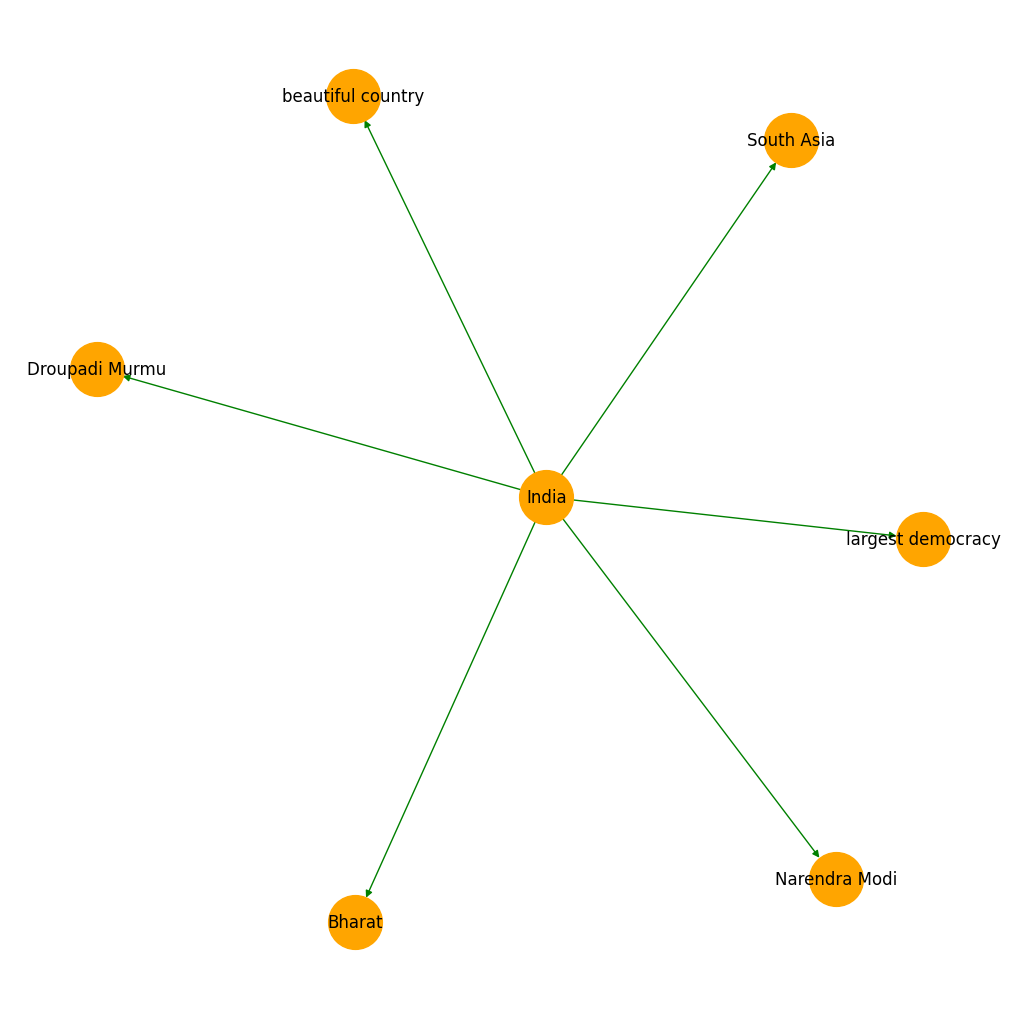

In [19]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(KG_India)
nx.draw(KG_India, with_labels=True, node_color='orange', edge_color='green', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

# **Constructing Knowledge Graph on Large *unstructured* text**

## **Import wikipedia sentences**

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
unstructured_text = pd.read_csv("/content/drive/MyDrive/mini_project/saurav/Virat_Kohli_sentences.csv")
unstructured_text.shape

(685, 1)

In [ ]:
unstructured_text['sentence'].sample(10)

381    He finished the series with 12 runs in 2 innings at an average of 6, a high score of 11, anyhow India won the series 2–1 Kohli was selected to play during the first ODI but was ruled out due an in...
289                                                                              India went on to wrap the series 2–0 and briefly top the ICC Test Rankings before being displaced by Pakistan at the position
0                                  Virat Kohli (Hindi pronunciation: [ʋɪˈɾɑːʈ ˈkoːɦli] ; born 5 November 1988) is an Indian international cricketer and the former captain of the Indian national cricket team
25     Upon the suggestion of their neighbours, Kohli's father considered enrolling his son in a professional cricket academy, as they believed that his cricketing abilities merited more than just playin...
114                                                                                 Kohli finished as the tournament's leading run-scorer, with a total of 398 runs from sev

In [23]:
unstructured_text.head(20)

,sentence
0,Virat Kohli (Hindi pronunciation: [ʋɪˈɾɑːʈ ˈkoːɦli] ; born 5 November 1988) is an Indian international cricketer and the former captain of the Indian national cricket team
1,He is a right-handed batsman and an occasional medium-fast bowler
2,He currently represents Royal Challengers Bangalore in the IPL and Delhi in domestic cricket
3,Kohli is widely regarded as one of the greatest batsmen in the history of cricket and the best of the 21st century
4,"He holds the record as the highest run-scorer in T20I and IPL, ranks third in ODI, and stands as the fourth-highest in international cricket"
5,He also holds the record for scoring the most centuries in ODI cricket and stands second in the list of most international centuries scored
6,"Kohli was a member of the Indian team that won the 2011 Cricket World Cup, 2013 ICC Champions Trophy, and captained India to win the ICC Test mace three consecutive times in 2017, 2018, and 2019...."
7,"In 2015, he achieved the summit of T20I rankings"
8,"In 2018, he was ranked top Test batsman, making him the only Indian cricketer to hold the number one spot in all three formats of the game"
9,"He is the first player to score 20,000 runs in a decade"


## **Extract Entities from *unstructured* text**

In [24]:
entity_pairs = []

for i in tqdm(unstructured_text["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 685/685 [00:07<00:00, 94.78it/s]


In [25]:
entity_pairs[5:10]

[['He', 'most international'],
 ['2019.In 2013 Kohli', 'ODI batsmen'],
 ['he', 'T20I rankings'],
 ['top Test him', 'three game'],
 ['He', '20,000 decade']]

 Extract relations from *unstructured* text

In [26]:
relations = [get_relation(i) for i in tqdm(unstructured_text['sentence'])]

100%|██████████| 685/685 [00:06<00:00, 107.95it/s]


## *Create dataframe in <*source, target, edge*> format*

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [27]:

source = [i[0] for i in entity_pairs]

target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.head(6)


,source,target,edge
0,ʋɪˈɾɑːʈ born,national cricket team,is
1,He,medium fast,is
2,He,domestic cricket,represents
3,Kohli,21st century,regarded as
4,He,international cricket,holds
5,He,most international,holds


### **Show top *50* relations**

In [28]:
pd.Series(relations).value_counts()[:50]

scored           56
was              27
made             20
became           19
amassed          10
managed          10
achieved          9
had               8
is                8
won               8
earned            7
found             7
went              7
struck            6
expressed         6
contributed       6
toured            6
reached           5
helped            5
established       5
selected          5
continued         5
marked            4
included in       4
named             4
selected in       4
averaged          4
lost              4
dismissed for     4
came              4
returned to       4
faced             4
has               4
ended in          4
played in         4
ended             4
awarded           4
entered into      3
exhibited         3
encountered       3
failed            3
acknowledged      3
retained by       3
fell short        3
surpassed         3
suffered          3
announced         3
been              3
accomplished      3
batted            3


## **Construct and Plot Knowledge Graph for *unstructured* text**

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

In [29]:
# Construct knowledge graph over extracted information (dataframe)
KG = nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

# Plot Knowledge Graph
plt.figure(figsize=(12,12))
pos = nx.spring_layout(KG)
nx.draw(KG, with_labels=True, node_color='orange', edge_color='green', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()



Output hidden; open in https://colab.research.google.com to view.

 It becomes really hard to visualize a graph with these many relations or predicates.

## **Construct knowledge graph for a *single* relation**

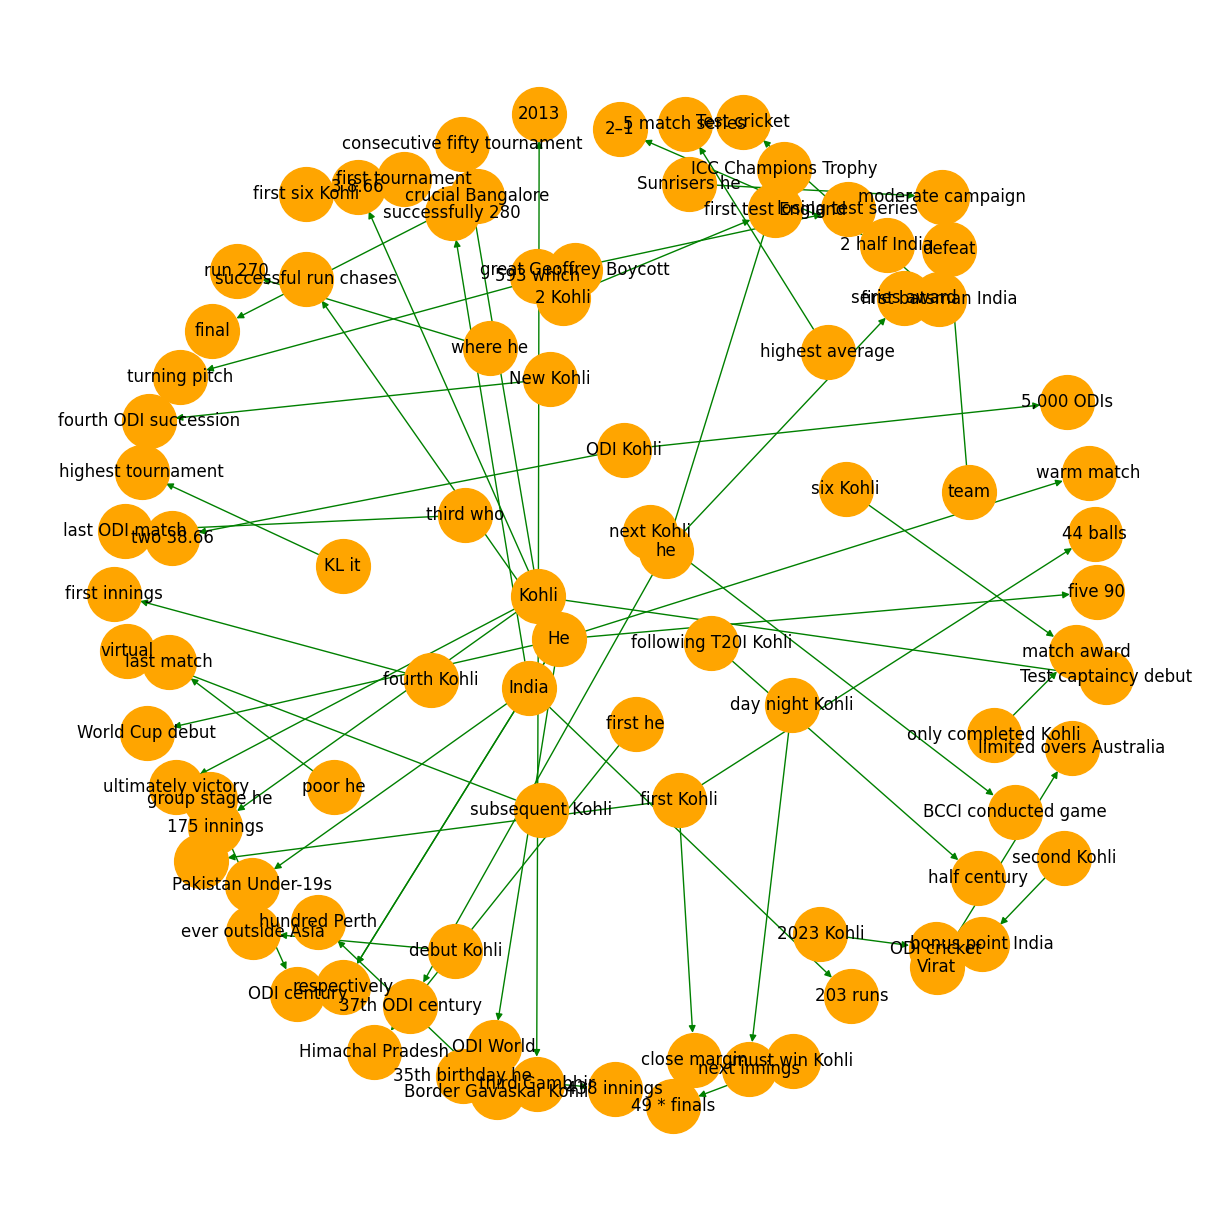

In [30]:
KG_rel = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="scored"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
nx.draw(KG_rel, with_labels=True, node_color='orange',edge_color='green', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

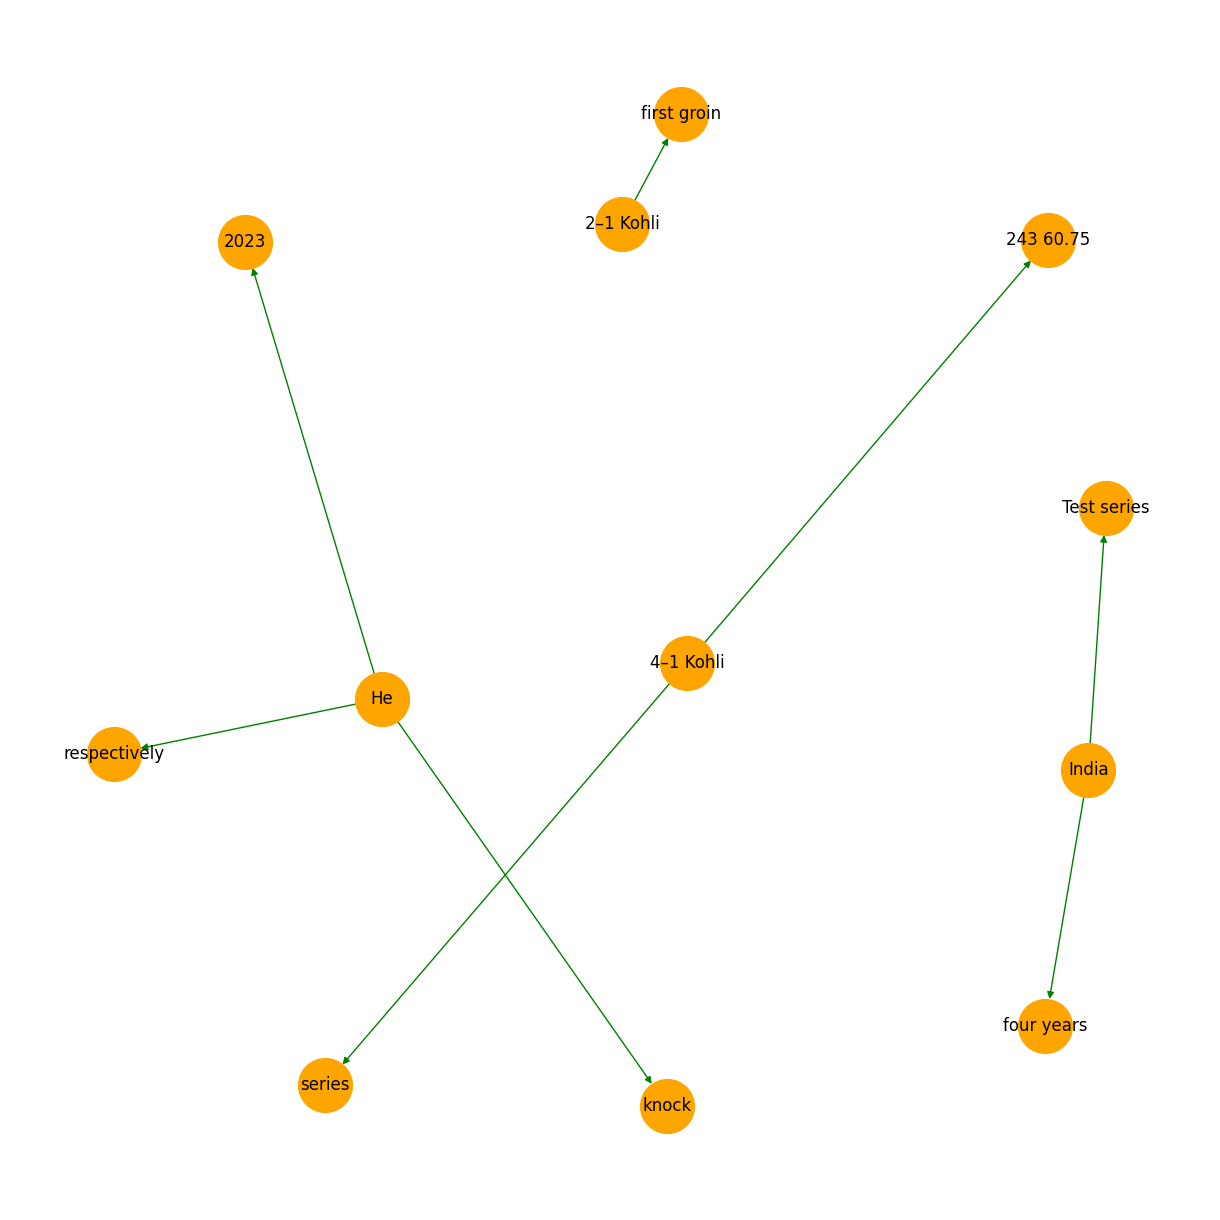

In [31]:
KG_rel = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="won"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
nx.draw(KG_rel, with_labels=True, node_color='orange',edge_color='green', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [36]:
import pandas as pd

# Convert relations to a Pandas Series and count the occurrences of each relation
relation_series = pd.Series(relations)
relation_counts = relation_series.value_counts()

# Take the top 5 relations with the highest frequencies
top_relations = relation_counts[:5]

# Extract the index (relation) from the top_relations
useful_relations = top_relations.index.tolist()

print("Top 5 relations:", useful_relations)


Top 5 relations: ['scored', 'was', 'made', 'became', 'amassed']


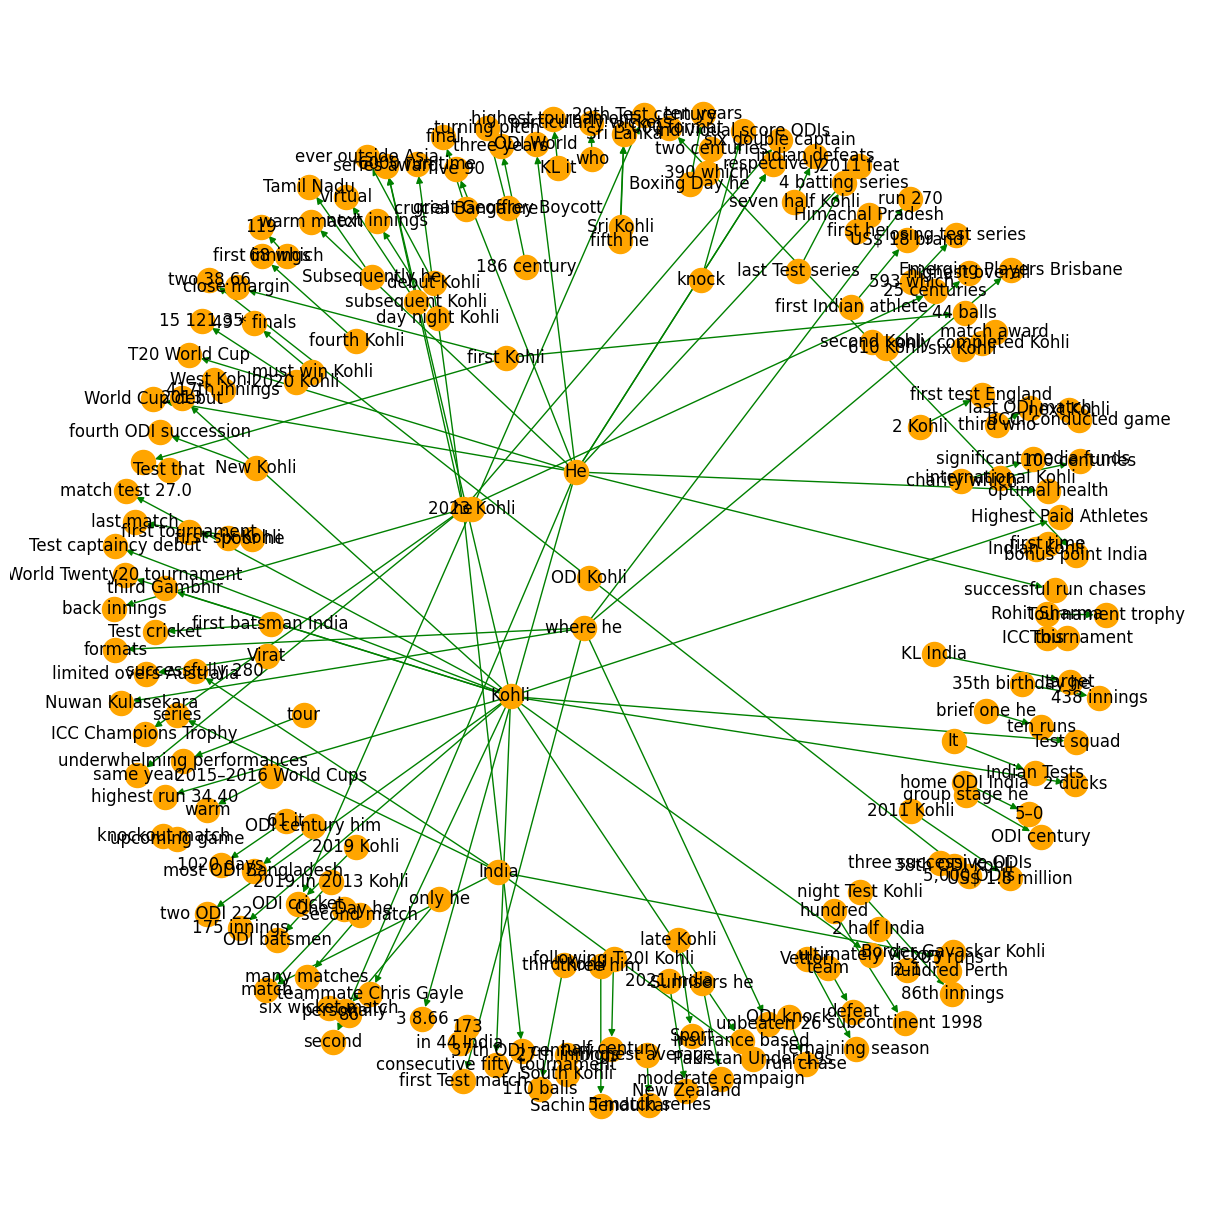

In [37]:
# Filter relations based on the top 5 most frequent relations
filtered_relations = [rel for rel in relations if rel in useful_relations]

# Construct the DataFrame with filtered relations
kg_df_filtered = kg_df[kg_df['edge'].isin(filtered_relations)]

# Construct the Knowledge Graph with filtered relations
KG_filtered = nx.from_pandas_edgelist(kg_df_filtered, "source", "target",
                                      edge_attr=True, create_using=nx.MultiDiGraph())

# Plot the Knowledge Graph
plt.figure(figsize=(12, 12))
pos_filtered = nx.spring_layout(KG_filtered)
nx.draw(KG_filtered, with_labels=True, node_color='orange', edge_color='green', edge_cmap=plt.cm.Blues, pos=pos_filtered)
plt.show()
